# Importing Libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, concatenate, BatchNormalization, MultiHeadAttention, LayerNormalization, LeakyReLU, Flatten,
                                      Embedding, Lambda, Add,  Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, LSTM)
from tensorflow.keras.optimizers import Adam
import json
import os
from keras.saving import register_keras_serializable
import joblib

C:\Users\LENOVO\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading and Exploration

In [2]:
excel_path = r'c:/Users/LENOVO/OneDrive/Desktop/capstone project/13059_2018_1459_MOESM5_ESM.xlsx'
xls = pd.ExcelFile(excel_path)
sheets = xls.sheet_names
dfs = {sheet: xls.parse(sheet) for sheet in sheets}

hct116_df=dfs['hct116']
hek293t_df=dfs['hek293t']
hela_df=dfs['hela']
hl60_df=dfs['hl60']

In [3]:
print(f'HCT116 shape: {hct116_df.shape}')
print(f'HEK293T shape: {hek293t_df.shape}')
print(f'HELA shape: {hela_df.shape}')
print(f'HL60 shape: {hl60_df.shape}')

HCT116 shape: (4239, 6)
HEK293T shape: (2333, 6)
HELA shape: (8101, 6)
HL60 shape: (2076, 6)


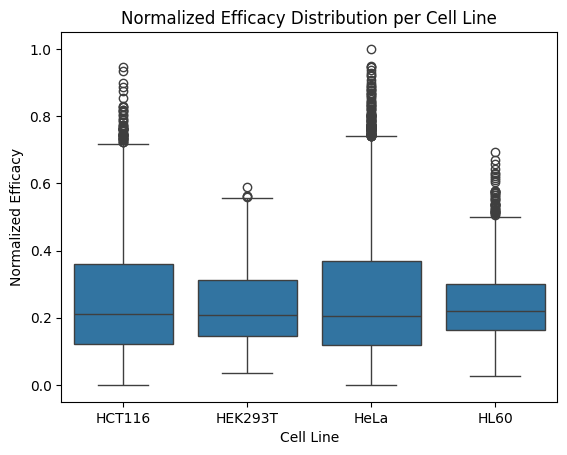

In [4]:
combined_df = pd.concat([
    hct116_df.assign(CellLine='HCT116'),
    hek293t_df.assign(CellLine='HEK293T'),
    hela_df.assign(CellLine='HeLa'),
    hl60_df.assign(CellLine='HL60')
])

sns.boxplot(data=combined_df, x='CellLine', y='Normalized efficacy')
plt.title('Normalized Efficacy Distribution per Cell Line')
plt.ylabel('Normalized Efficacy')
plt.xlabel('Cell Line')
plt.show()

In [5]:
'''
hct116_df.to_csv('hct116.csv', index=False)
hek293t_df.to_csv('hek293t.csv', index=False)
hela_df.to_csv('hela_df.csv', index=False)
hl60_df.to_csv('hl60_df.csv', index=False)
'''

"\nhct116_df.to_csv('hct116.csv', index=False)\nhek293t_df.to_csv('hek293t.csv', index=False)\nhela_df.to_csv('hela_df.csv', index=False)\nhl60_df.to_csv('hl60_df.csv', index=False)\n"

In [6]:
df=hela_df.copy()

In [7]:
df

,Chromosome,Start,End,Strand,sgRNA,Normalized efficacy
0,chr4,184605984,184606006,-,ACATCAGGTTACCTCTACCAAGG,0.177011
1,chr1,11736866,11736888,+,CTGATGCCAGCTAGTGGGCGAGG,0.001588
2,chr4,25379067,25379089,+,CTGTTTCCCATCCTTCCGGGTGG,0.498712
3,chr12,57936737,57936759,-,AATGTATGCACAGGGAACAGAGG,0.114708
4,chr2,131103494,131103516,-,CCAGACTCACCCGCTTGCCCAGG,0.250399
...,...,...,...,...,...,...
8096,chr4,155468162,155468184,-,CATCCATACCCACCAGGACCTGG,0.002780
8097,chr12,49073501,49073523,+,CATATGAGCTCAGCTGGCACAGG,0.191390
8098,chr3,113517136,113517158,-,GCTGATGAGCCAATTGACAGAGG,0.301494
8099,chr17,78111967,78111989,-,CACACTGACCATCACTCAGGCGG,0.841003


In [8]:
df.shape

(8101, 6)

In [9]:
print("Max:", round(df['Normalized efficacy'].max(),3))
print("Min:", round(df['Normalized efficacy'].min(),3))

p1 = df['Normalized efficacy'].quantile(0.25)
p2 = df['Normalized efficacy'].quantile(0.50)
p3 = df['Normalized efficacy'].quantile(0.75)

print("25th percentile (Q1):", round(p1,3))
print("50th percentile (Median):", round(p2,3))
print("75th percentile (Q3):", round(p3,3))

Max: 1.0
Min: 0.0
25th percentile (Q1): 0.12
50th percentile (Median): 0.207
75th percentile (Q3): 0.368


In [10]:
df.describe()

,Start,End,Normalized efficacy
count,8.101000e+03,8.101000e+03,8101.000000
mean,7.098261e+07,7.098263e+07,0.256920
std,5.319116e+07,5.319116e+07,0.182097
min,9.743900e+04,9.746100e+04,0.000000
25%,3.150304e+07,3.150306e+07,0.120073
50%,5.742865e+07,5.742867e+07,0.206531
75%,1.040774e+08,1.040774e+08,0.368067
max,2.450275e+08,2.450275e+08,1.000000


In [11]:
df.dtypes

Chromosome              object
Start                    int64
End                      int64
Strand                  object
sgRNA                   object
Normalized efficacy    float64
dtype: object

In [12]:
df.info

<bound method DataFrame.info of      Chromosome      Start        End Strand                    sgRNA  \
0          chr4  184605984  184606006      -  ACATCAGGTTACCTCTACCAAGG   
1          chr1   11736866   11736888      +  CTGATGCCAGCTAGTGGGCGAGG   
2          chr4   25379067   25379089      +  CTGTTTCCCATCCTTCCGGGTGG   
3         chr12   57936737   57936759      -  AATGTATGCACAGGGAACAGAGG   
4          chr2  131103494  131103516      -  CCAGACTCACCCGCTTGCCCAGG   
...         ...        ...        ...    ...                      ...   
8096       chr4  155468162  155468184      -  CATCCATACCCACCAGGACCTGG   
8097      chr12   49073501   49073523      +  CATATGAGCTCAGCTGGCACAGG   
8098       chr3  113517136  113517158      -  GCTGATGAGCCAATTGACAGAGG   
8099      chr17   78111967   78111989      -  CACACTGACCATCACTCAGGCGG   
8100       chr6   43521187   43521209      +  AAGGTGAGAAGACGGAACAGAGG   

      Normalized efficacy  
0                0.177011  
1                0.001588  
2      

In [13]:
df.isnull().sum()

Chromosome             0
Start                  0
End                    0
Strand                 0
sgRNA                  0
Normalized efficacy    0
dtype: int64

In [14]:
df.duplicated().sum()

0

# Data Augmentation

In [15]:
nucleotides = ['A', 'C', 'G', 'T']

def generate_sgrnas(sgRNA):
    augmented = []
    for i in nucleotides:
        for j in nucleotides:
            if sgRNA[0] == i and sgRNA[1] == j:
                continue
            new_sgRNA = i + j + sgRNA[2:]
            if len(new_sgRNA) == len(sgRNA):
                augmented.append(new_sgRNA)
    return random.sample(augmented, min(3, len(augmented))) #To ensure that the max augmented sample=16 (even if the more that 16) 

augmented_rows = []

for _, row in df.iterrows():
    sgRNA = row['sgRNA']
    aug_sgrnas = generate_sgrnas(sgRNA)
    for i in aug_sgrnas:
        new_row = row.copy()
        new_row['sgRNA'] = i
        augmented_rows.append(new_row)
        
df_augmented = pd.DataFrame(augmented_rows)

In [16]:
df_augmented.shape

(24303, 6)

In [17]:
df_combined= pd.concat([df, df_augmented], ignore_index=True)

In [18]:
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
'''
df_augmented.to_csv('hela_augmented.csv', index=False)
df_combined.to_csv('hela_combined.csv', index=False)
'''

"\ndf_augmented.to_csv('hela_augmented.csv', index=False)\ndf_combined.to_csv('hela_combined.csv', index=False)\n"

In [20]:
df=df_combined.copy()

In [21]:
df.shape

(32404, 6)

# Feature Engineering

In [22]:
def gc_content(seq):
    gc_count = seq.count('G') + seq.count('C')
    return (gc_count / len(seq)) * 100

df['GC content']= df['sgRNA'].apply(gc_content)

In [23]:
print("Minimum GC Content: " , round(df['GC content'].min(),3))
print("Maximum GC Content: ", round(df['GC content'].max(),3))

Minimum GC Content:  39.13
Maximum GC Content:  82.609


In [24]:
df['Length'] = df['sgRNA'].apply(len)
df['Length'].value_counts()

Length
23    32404
Name: count, dtype: int64

In [25]:
df['sgRNA_noPAM'] = df['sgRNA'].apply(lambda x: x[:-3])
df['Length_noPAM'] = df['sgRNA_noPAM'].apply(len)

In [26]:
df['Length_noPAM'].value_counts()

Length_noPAM
20    32404
Name: count, dtype: int64

In [27]:
df.columns

Index(['Chromosome', 'Start', 'End', 'Strand', 'sgRNA', 'Normalized efficacy',
       'GC content', 'Length', 'sgRNA_noPAM', 'Length_noPAM'],
      dtype='object')

In [28]:
df=df.drop(['Length','Length_noPAM', 'sgRNA'], axis=1)
df

,Chromosome,Start,End,Strand,Normalized efficacy,GC content,sgRNA_noPAM
0,chr11,18505527,18505549,-,0.125611,56.521739,AGTGAGATGGCGGATGAAGG
1,chr11,64785925,64785947,+,0.299039,65.217391,TGAAGACCCTGGAGCACCGA
2,chr12,57925788,57925810,+,0.783166,65.217391,CCGCACACACCTGGGTCAAG
3,chr4,122735048,122735070,+,0.135277,52.173913,AGGAACTGCCCAAATTGGAG
4,chr17,1779079,1779101,-,0.441797,52.173913,GAGCAACAACTCACTTGGAC
...,...,...,...,...,...,...,...
32399,chr19,7998771,7998793,-,0.091170,56.521739,GCCGGGAGATAAGTTCAAGG
32400,chr14,61442174,61442196,+,0.161761,52.173913,TTTCCCAGAAACTGCTCACC
32401,chr16,4496898,4496920,-,0.173659,73.913043,CGCCGTCCCTCCGGAACACA
32402,chr19,54647858,54647880,-,0.616186,60.869565,GTCAACTCACCGTGAGCCAC


# One Hot Encoding

In [29]:
nucleotides = ['A', 'T', 'C', 'G']
encoder = OneHotEncoder(categories=[nucleotides], handle_unknown='ignore')
def one_hot_encoder(sequence):
    seq_arr = np.array(list(sequence)).reshape(-1, 1)
    return encoder.fit_transform(seq_arr).toarray()

result = df['sgRNA_noPAM'].apply(one_hot_encoder)
one_hot_arr = np.stack(result.to_numpy())  # shape: (samples, seq_len, 4)

joblib.dump(encoder, 'preprocessing/hela_encoder.pkl')

['preprocessing/hela_encoder.pkl']

# Data Preperation & Splitting with One Hot Encoding

In [30]:
strand_map = {'+': 0, '-': 1}
df['Strand'] = df['Strand'].map(strand_map)
df['Chromosome_number'] = df['Chromosome'].str.replace('chr', '', regex=False).astype(str)
df['Chromosome_number'] = df['Chromosome_number'].replace({'X': 23})
df['Chromosome_number'] = df['Chromosome_number'].astype(int)
df=df.drop(['Chromosome'], axis=1)

features_df = df[['Chromosome_number', 'Strand','GC content']].copy()

y = df['Normalized efficacy'].values

X_seq_train, X_seq_test, X_feat_train_df, X_feat_test_df, y_train, y_test = train_test_split(
    one_hot_arr, features_df, y, test_size=0.2, random_state=42
)

scaler_gc = MinMaxScaler()
X_feat_train_df['GC content'] = scaler_gc.fit_transform(X_feat_train_df[['GC content']])
X_feat_test_df['GC content'] = scaler_gc.transform(X_feat_test_df[['GC content']])
joblib.dump(scaler_gc, 'preprocessing/hela_gc_minmax_scaler.pkl')

X_num_train = X_feat_train_df.values
X_num_test = X_feat_test_df.values

# Saving models

In [31]:
def save_run(type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots):

    dir = os.path.join("/Users/LENOVO/OneDrive/Desktop/CRISPR PROJECT", "Best Performing Models/ hela")
    os.makedirs(dir, exist_ok=True)

    plot_paths = {}
    for name, fig in plots.items():
        path = os.path.join(dir, f"{name}_run{run_id}.png")
        fig.savefig(path)
        plt.close(fig)
        plot_paths[name] = path

    model_arch_path = None
    if model is not None:
        model_arch_path = os.path.join(dir, f"model_architecture_run_{run_id}.txt")
        with open(model_arch_path, "w", encoding="utf-8") as f:
            model.summary(print_fn=lambda x: f.write(x + "\n"))
    
    model_file_path = None
    if model is not None:
        model_file_path = os.path.join(dir, f"model_run_{run_id}.keras")
        model.save(model_file_path) 

    run = {
        "Model:": type,
        "Run_id": run_id,
        "Data": data,
        "Encoding Method": encoding_method,
        "Feature Engineering": feature_engineering,
        "Hyperparameters": hyperparameters,
        "Evaluation Metrics": metrics,
        "Plots": plot_paths,
        "Model Architecture": model_arch_path,
        "Model Path": model_file_path
    }

    json_path = os.path.join(dir, "runs.json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run)

    with open(json_path, "w") as f:
        json.dump(all_runs, f, indent=2)
        
    print("Done")

# BiLSTM with Attention

In [32]:
seq_len=20 
d_model = 16 

seq_input = Input(shape=(seq_len,4), name='seq_input') 

x = Dense(d_model, use_bias=False)(seq_input)  # (Projection)
position_embed = Embedding(input_dim=seq_len, output_dim=d_model)

def add_positional_encoding(t):
    pe = position_embed(tf.range(seq_len))                        
    return t + tf.expand_dims(pe, 0)

x = Lambda(add_positional_encoding, name='add_pos')(x)  

attention_output = MultiHeadAttention(num_heads=2, key_dim=d_model // 2, dropout=0.1, name='self_attn')(x, x)  

x = Add(name='attn_res')([x, attention_output])
x = LayerNormalization(name='attn_ln')(x)     

x1 = Bidirectional(LSTM(64, return_sequences=True))(x)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = BatchNormalization()(x1)

features_input = Input(shape=(X_num_train.shape[1],), name='num_input')
x2 = Dense(64, activation='relu', kernel_initializer='he_normal')(features_input)
x2 = BatchNormalization()(x2)

all_input = concatenate([x1, x2])
z = Dense(128, activation='relu', kernel_initializer='he_normal')(all_input)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(64, activation='relu', kernel_initializer='he_normal')(z)
z = Dense(1, activation='linear')(z)

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model = Model(inputs=[seq_input, features_input], outputs=z)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    {'seq_input': X_seq_train, 'num_input': X_num_train},
    y_train,
    validation_data=({'seq_input': X_seq_test, 'num_input': X_num_test}, y_test),
    epochs= 350,
    batch_size= 32
)


Epoch 1/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.3070 - mae: 0.4108 - val_loss: 0.0446 - val_mae: 0.1658
Epoch 2/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0547 - mae: 0.1845 - val_loss: 0.0382 - val_mae: 0.1484
Epoch 3/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0424 - mae: 0.1631 - val_loss: 0.0347 - val_mae: 0.1470
Epoch 4/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0368 - mae: 0.1522 - val_loss: 0.0344 - val_mae: 0.1434
Epoch 5/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 0.0346 - mae: 0.1482 - val_loss: 0.0330 - val_mae: 0.1434
Epoch 6/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0346 - mae: 0.1484 - val_loss: 0.0326 - val_mae: 0.1433
Epoch 7/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0337 - mae: 0.1469 - val_loss: 0.0329 - val_mae: 0.1398
Epoch 8/350
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0331 - mae: 0.1450 - val_loss: 0.0320 - val_mae: 0.1408
Epoch 9/350
811/811 ━━━━━━━━━━━

In [33]:
y_pred= model.predict({'seq_input': X_seq_test, 'num_input': X_num_test})
y_pred = y_pred.ravel()
y_test = y_test.ravel()

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [34]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Spearman': spearman_corr
}

print("MLP Evaluation Metrics:")
print(f"  MSE      : {round(mse,3)}")
print(f"  RMSE     : {round(rmse,3)}")
print(f"  MAE      : {round(mae,3)}")
print(f"  R2 Score : {round(r2,3)}")
print(f"  Spearman : {round(spearman_corr,3)}")

MLP Evaluation Metrics:
  MSE      : 0.001
  RMSE     : 0.025
  MAE      : 0.018
  R2 Score : 0.981
  Spearman : 0.988


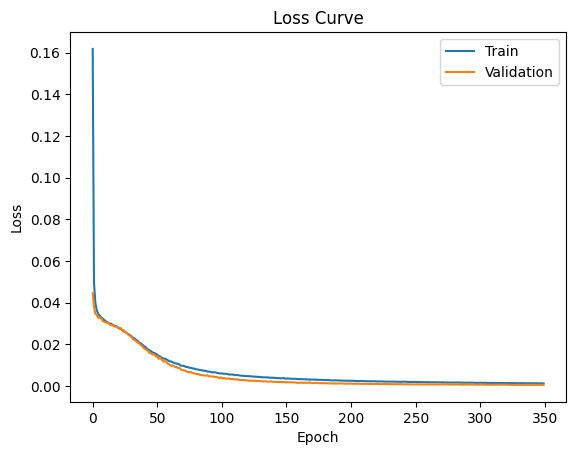

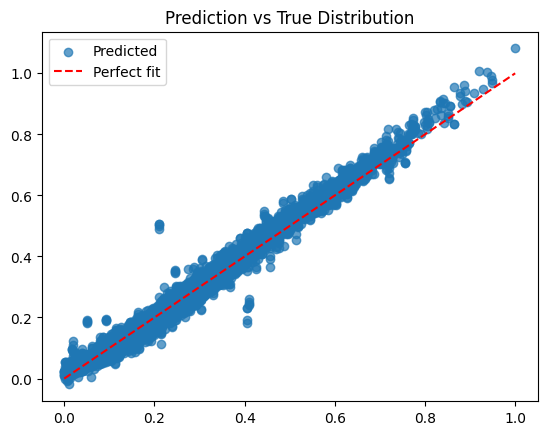

In [35]:
fig1, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_xlabel('Epoch')        
ax1.set_ylabel('Loss') 
ax1.set_title('Loss Curve')
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred, alpha=0.7, label='Predicted')
ax2.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect fit') 
ax2.set_title('Prediction vs True Distribution')
ax2.legend()

In [36]:
data= "Augmented Data"
encoding_method= '1 Hot Encoding + PE'
feature_engineering= "With Feature Engineering"
run_id = 1
model_type = "BiLSTM + Attention"
hyperparameters = {
    "epochs": 350,
    "batch_size": 32,
    "learning_rate": 1e-4
}

plots = {
    "Loss Curve": fig1,
    "Predicted vs. True Distribution": fig2
}

save_run(model_type, model, data, encoding_method, feature_engineering, run_id, hyperparameters, metrics, plots)

Done


In [37]:
def mc_confidence(model, X_seq, X_num, n_iter=30):
    predictions = []

    for _ in range(n_iter):
        prediction = model([X_seq, X_num], training=True).numpy()
        predictions.append(prediction)

    predictions = np.array(predictions)
    mean = predictions.mean(axis=0)
    std = predictions.std(axis=0)
    return mean, std

In [38]:
mean, std = mc_confidence(model, X_seq_test, X_num_test, n_iter=30)

print("Mean Prediction:", mean[:10].squeeze())
print("Confidence (± std):", std[:10].squeeze())

Mean Prediction: [0.08925822 0.6067701  0.5054391  0.07948735 0.17050304 0.25134164
 0.30835733 0.2648273  0.10422194 0.05342547]
Confidence (± std): [0.0183151  0.03608574 0.05217626 0.01703484 0.02396721 0.02161232
 0.02412638 0.03660692 0.02148729 0.01658651]
